In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn import feature_selection as fs
from sklearn import preprocessing as pp
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from boruta import BorutaPy

In [3]:
def read_and_get_data():
    train_data = pd.read_csv('./training.csv')
    test_data = pd.read_csv('./testing.csv')
    train_data = split_datetime(train_data)
    test_data = split_datetime(test_data)
    
    x_train = catogirical_to_numerical(train_data.drop(['Appliances'], axis = 1))
    y_train = train_data['Appliances'].values

    x_test = catogirical_to_numerical(test_data.drop(['Appliances'], axis = 1))
    y_test = test_data['Appliances'].values
    return x_train, y_train, x_test, y_test

def low_variance_selector(var_per):
    return fs.VarianceThreshold(threshold=(var_per*(1-var_per)))

def univariant_selector(univariant_per):
    return fs.SelectPercentile(fs.mutual_info_regression, percentile=univariant_per)

def RFE_selector(num):
    return fs.RFE(estimator=LinearRegression(), n_features_to_select=num, step = 1)

def boruta_selector():
    return BorutaPy(RandomForestRegressor(max_depth=100,n_estimators=10), verbose=2, random_state=1)

In [4]:
def catogirical_to_numerical(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df[col] = df[col].astype('category')
    vec = DictVectorizer(sparse=False, dtype=int)
    dc = df.to_dict('records')
    result = vec.fit_transform(dc)
    return result
def split_datetime(df):
    df['date'] = pd.to_datetime(df['date'])
    year = list()
    month = list()
    day = list()
    hour=list()
    for i in np.arange(df.count()[0]):
        year.append(df['date'][i].year)
        month.append(df['date'][i].month)
        day.append(df['date'][i].day)
        hour.append(df['date'][i].hour)
    df['year'] = year
    df['month'] = month
    df['day'] = day
    df['hour'] = hour
    df = df.drop(['date'], axis = 1)
    return df

In [5]:
def gen_linear_pipeline(vp, up, num, degree=2):
    return make_pipeline(low_variance_selector(vp),
                         univariant_selector(up),
                         RFE_selector(num),
                         pp.PolynomialFeatures(degree),
                         LinearRegression()
                        )

def gen_rf_pipeline(vp, up, num, md, ne, degree=2):
    return make_pipeline(low_variance_selector(vp),
                         univariant_selector(up),
                         RFE_selector(num),
                         pp.PolynomialFeatures(degree),
                         RandomForestRegressor(max_depth=md, n_estimators=ne)
                        )

def gen_nn_pipeline(vp, up, num, hls, al=0.0001, degree=2):
    return make_pipeline(low_variance_selector(vp),
                         univariant_selector(up),
                         RFE_selector(num),
                         pp.MinMaxScaler(copy=False, feature_range=(-1,1)),
                         pp.PolynomialFeatures(degree),
                         MLPRegressor(hidden_layer_sizes=hls, alpha=al)
                        )

In [6]:
def test_regressor(x_train,x_test,y_train,y_test,degree):    
    x_transform = low_variance_selector(0.8).fit_transform(x_train, y_train)
    x_transform = univariant_selector(90).fit_transform(x_transform, y_train)
    x_transform = RFE_selector(15).fit_transform(x_transform, y_train)
    x_transform = pp.PolynomialFeatures(degree).fit_transform(x_transform, y_train)
    rf = RandomForestRegressor(max_depth=100)
    rf.fit(x_transform,y_train)

    test_transform = low_variance_selector(0.8).fit_transform(x_test, y_test)
    test_transform = univariant_selector(90).fit_transform(test_transform, y_test)
    test_transform = RFE_selector(15).fit_transform(test_transform, y_test)
    test_transform = pp.PolynomialFeatures(degree).fit_transform(test_transform, y_test)
    y_pred = rf.predict(test_transform)
    return y_pred

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def cal_errors(y_test,y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rms = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print('MAE = {}, RMS = {}, R2 = {}, MAPE = {}'.format(mae,rms,r2,mape))

def draw_plot(y_test,y_pred):
    plt.figure(figsize=(10,10))
    plt.plot(np.arange(len(y_pred)), np.sort(y_pred), color='blue', linewidth=1)

    plt.plot(np.arange(len(y_test)), np.sort(y_test), color='red', linewidth=1)

    plt.xticks(())
    plt.yticks(())

    plt.show()

##### Test pipelines

In [7]:
x_train, y_train, x_test, y_test = read_and_get_data()
linear = gen_linear_pipeline(0.8,90,15,degree=2)
linear = linear.fit(x_train,y_train)
y_pred = linear.predict(x_test)
cal_errors(y_test,y_pred)

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


MAE = 50.73260562560809, RMS = 8057.847354632767, R2 = 0.219452786235231, MAPE = 58.36786846541271


In [8]:
x_train, y_train, x_test, y_test = read_and_get_data()
rf = gen_rf_pipeline(0.8,90,15,100,50,degree=2)
rf = rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
cal_errors(y_test,y_pred)

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


MAE = 35.97617772667945, RMS = 5815.403137108848, R2 = 0.4366737770256409, MAPE = 36.31933894205706


In [9]:
x_train, y_train, x_test, y_test = read_and_get_data()
nn = gen_nn_pipeline(0.8,90,15,15,degree=2)
nn = nn.fit(x_train,y_train)
y_pred = nn.predict(x_test)
cal_errors(y_test,y_pred)

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


MAE = 51.31647674149519, RMS = 8255.023194698382, R2 = 0.20035276537215796, MAPE = 59.394702629079866


c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### 3. Cross Validation

In [10]:
x_train, y_train, x_test, y_test = read_and_get_data()
scores = cross_val_score(gen_rf_pipeline(0.8,90,15,100,50,degree=2), x_train, y_train, scoring='r2', cv = 10)

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnin

In [11]:
scores

array([-0.49583562, -0.67365869, -0.02929956, -0.03883414, -0.08052938,
       -0.16002669, -0.03291964, -0.20758099, -0.72507949, -0.60733696])

### Validation Curve

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnin

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnin

Text(0, 0.5, 'score')

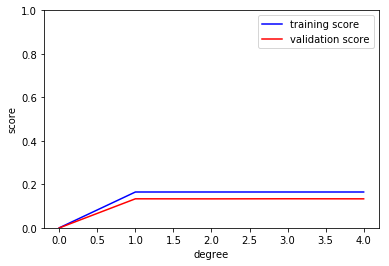

In [13]:
degree = np.arange(0,5)
train_score, val_score = validation_curve(gen_rf_pipeline(0.8,5,25,100,100), x_train, y_train,
                                          'polynomialfeatures__degree',degree, scoring='r2', cv=5)

plt.plot(degree, np.mean(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnin

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnin

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnin

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnin

Text(0, 0.5, 'score')

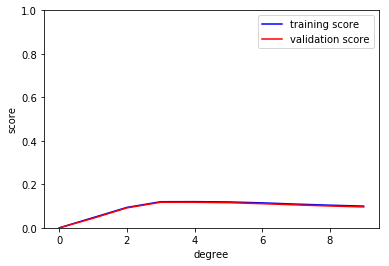

In [14]:
degree = np.arange(0,10)
train_score, val_score = validation_curve(gen_linear_pipeline(0.8,5,25), x_train, y_train,
                                          'polynomialfeatures__degree',degree, scoring='r2', cv=5)

plt.plot(degree, np.mean(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')

In [32]:
train_score

array([[-58.4192477 , -60.78447946, -61.7361336 , -61.17832318,
        -62.90993049],
       [-54.43083955, -56.52273068, -57.7964553 , -56.6466487 ,
        -58.32141432],
       [-55.44410041, -57.57645373, -58.60851768, -57.88104502,
        -59.70465236],
       [-51.12602699, -53.46602051, -54.51658778, -53.65464842,
        -55.15042417],
       [-51.46434935, -53.53461026, -54.7955939 , -53.92418101,
        -55.38785422],
       [-51.02104324, -53.42195976, -54.32632614, -53.42814507,
        -54.98889531],
       [-50.77960652, -53.37475716, -54.22902872, -53.43183911,
        -54.97666178],
       [-51.1269851 , -53.74199927, -54.6536259 , -53.83046272,
        -55.28119178],
       [-51.57131757, -54.02418463, -55.12892045, -54.37938313,
        -55.73649008],
       [-52.12897695, -54.30931119, -55.62593799, -54.8702648 ,
        -56.15246731]])

In [33]:
val_score

array([[-72.67185253, -61.21451298, -58.95128137, -58.71663955,
        -53.52050276],
       [-68.46304379, -56.84538022, -53.96488466, -54.64177422,
        -50.11260916],
       [-68.62562885, -56.77956809, -56.09734002, -56.29949167,
        -52.05363842],
       [-64.95063893, -52.38743038, -51.43985286, -51.83057878,
        -48.29895621],
       [-65.27790448, -52.68206444, -51.66789792, -52.01196115,
        -48.45433205],
       [-65.13563259, -52.62666038, -51.13084278, -51.35530217,
        -47.97834358],
       [-65.50484489, -52.79101977, -50.91694541, -50.98535163,
        -47.67245504],
       [-66.12104313, -53.42059171, -51.25082554, -51.01860438,
        -47.74515581],
       [-66.75897489, -54.05571175, -51.68799667, -51.24701676,
        -48.06920559],
       [-67.41463859, -54.7377766 , -52.13906444, -51.47333046,
        -48.35399383]])

### Grid Search

In [22]:
nn = gen_nn_pipeline(0.8,90,15,15,degree=2)
parameters = {'mlpregressor__hidden_layer_sizes':[10,14,18,22],
              'mlpregressor__learning_rate':('constant','invscaling','adaptive')}
clf = GridSearchCV(nn, parameters, cv = 5, scoring='r2')
clf.fit(x_train,y_train)

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimizati

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by 

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by 

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by 

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by 

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by 

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.15999999999999998)), ('selectpercentile', SelectPercentile(percentile=90,
         score_func=<function mutual_info_regression at 0x1B425F60>)), ('rfe', RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         no...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'mlpregressor__hidden_layer_sizes': [10, 14, 18, 22], 'mlpregressor__learning_rate': ('constant', 'invscaling', 'adaptive')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [18]:
nn.get_params().keys()

dict_keys(['memory', 'steps', 'variancethreshold', 'selectpercentile', 'rfe', 'minmaxscaler', 'polynomialfeatures', 'mlpregressor', 'variancethreshold__threshold', 'selectpercentile__percentile', 'selectpercentile__score_func', 'rfe__estimator__copy_X', 'rfe__estimator__fit_intercept', 'rfe__estimator__n_jobs', 'rfe__estimator__normalize', 'rfe__estimator', 'rfe__n_features_to_select', 'rfe__step', 'rfe__verbose', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'mlpregressor__activation', 'mlpregressor__alpha', 'mlpregressor__batch_size', 'mlpregressor__beta_1', 'mlpregressor__beta_2', 'mlpregressor__early_stopping', 'mlpregressor__epsilon', 'mlpregressor__hidden_layer_sizes', 'mlpregressor__learning_rate', 'mlpregressor__learning_rate_init', 'mlpregressor__max_iter', 'mlpregressor__momentum', 'mlpregressor__n_iter_no_change', 'mlpregressor__nesterovs_momentum', 'mlpregressor_

In [25]:
clf.best_params_

{'mlpregressor__hidden_layer_sizes': 10,
 'mlpregressor__learning_rate': 'adaptive'}

### Regularization

MLPRegressor use parameter alpha for regularization (L2 regularization) term which helps in avoiding overfitting by penalizing weights with large magnitudes

In [34]:
nn = gen_nn_pipeline(0.8,90,15,15,degree=2)
parameters = {'mlpregressor__alpha':[0.00001,0.0001,0.001,0.01],
              'polynomialfeatures__degree':[2,3]}
clf = GridSearchCV(nn, parameters, cv = 5, scoring='r2')
clf.fit(x_train,y_train)

c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\administrator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimizati

MemoryError: 

In [28]:
train_score

array([[0.19768214, 0.19623347, 0.20737489, 0.22347729, 0.21748618],
       [0.22052054, 0.21813009, 0.24122986, 0.1752528 , 0.22466614],
       [0.19701519, 0.21508706, 0.22968159, 0.16214805, 0.21518556],
       [0.20403773, 0.20514653, 0.22064016, 0.20228199, 0.21102523],
       [0.19844388, 0.19731763, 0.21725159, 0.16528464, 0.21432425],
       [0.22954324, 0.20019312, 0.23267433, 0.1728586 , 0.22410088]])

In [29]:
val_score

array([[-0.28844561,  0.06925945,  0.12996449,  0.17061902, -0.36097357],
       [-0.25928604,  0.08341699,  0.10070895,  0.12562802, -0.68669312],
       [-0.18646203,  0.06116286,  0.13104904,  0.14863274, -0.79236466],
       [-0.20739749,  0.07164037,  0.11790251,  0.15538362, -1.05609813],
       [-0.22142802,  0.04990565,  0.12755907,  0.126624  , -0.63265547],
       [-0.22797023,  0.08292343,  0.10993865,  0.12460444, -0.67475041]])